In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import FastEmbedSparse, RetrievalMode
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain_huggingface import HuggingFaceEmbeddings


from typing import Literal
from pydantic import BaseModel, Field
from database import add_item_to_cart_by_name

import config

# Setup

In [2]:
url = config.QDRANT_URL
api_key = config.QDRANT_API_KEY

sparse_embeddings = FastEmbedSparse(
    model_name="Qdrant/bm25"
)

model_name = "jinaai/jina-embeddings-v3"
model_kwargs = {'device': 'cuda', 'trust_remote_code':True}
encode_kwargs = {'normalize_embeddings': False}
jina_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

embeddings = jina_embeddings

product_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    url=config.QDRANT_URL,
    prefer_grpc=True,
    api_key=config.QDRANT_API_KEY,
    collection_name="flowers",
    retrieval_mode=RetrievalMode.HYBRID,
)


policy_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    url=config.QDRANT_URL,
    prefer_grpc=True,
    api_key=config.QDRANT_API_KEY,
    collection_name="flowers_policy",
    retrieval_mode=RetrievalMode.HYBRID,
)


groq_llama3_1_70b = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    api_key=config.GROQ_API_KEY
)

Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

# 1. Define Graph State

In [2]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from langchain_core.documents import Document


class GraphState(MessagesState):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        final_answer: LLM generation
        recommend_docs: list of documents
    """
    groq_llama3_1_70b: ChatGroq
    product_qdrant: QdrantVectorStore
    policy_qdrant: QdrantVectorStore
    query: str
    final_answer: str
    recommend_products: List[str]
    supervisor_route_choice: str
    cust_id: str

# 2. Define Nodes

In [3]:
# Supervisor Node

def supervisor_agent(state):
    query = state['query']
    groq_llama3_1_70b = state['groq_llama3_1_70b']

    # Data model
    class SupervisorRoute(BaseModel):
        """Route a user query to the most relevant datasource."""

        route: Literal["product_recommendation_agent", "policy_agent", "cart_agent", "apology_agent"] = Field(
            description="Given a user question choose to route it to vector_store_agent or apology_agent. ",
        )


    structured_supervisor_llm = groq_llama3_1_70b.with_structured_output(SupervisorRoute)

    # Prompt
    system = """You are an expert at delegating a user query to an appropriate agent.
    if the user query involved product recommendation:
        delegate to "product_recommendation_agent"
    if the user query involve policy question:
        delegate to "policy_agent"
    if the user query involve adding items to cart:
        delegate to "cart_agent"
    if the user query are not related to product recommendation, policy, cart:
        delegate to "apology_agent"
    """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )

    supervisor_agent = route_prompt | structured_supervisor_llm

    supervisor_choice = supervisor_agent.invoke(query)

    return {"supervisor_route_choice": supervisor_choice.route}

# Recommendation Agent
def product_recommendation_agent(state):
    query = state['query']
    product_qdrant = state['product_qdrant']

    # -----------------------------------------------------------------
    # 1. Retrieval
    # -----------------------------------------------------------------

    compressor = FlashrankRerank(
        model="ms-marco-MiniLM-L-12-v2",
        top_n=5
    )

    product_hybrid_rerank_qdrant_retriever = product_qdrant.as_retriever(
        search_type="similarity", 
        search_kwargs={"k": 20},
    )
    
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=product_hybrid_rerank_qdrant_retriever
    )

    recommend_docs = compression_retriever.invoke(query)

    # Format the docs
    recommend_docs_context = "\n\n".join(doc.page_content for doc in recommend_docs)

    # -----------------------------------------------------------------
    # 2. Recommendation Text Generation
    # -----------------------------------------------------------------
    # Prompt
    recommend_template = """
    You are a persuasive product recommendation assistant.  
    Your goal is to recommend products in a compelling and confident manner based on the context and user’s needs.  
    Use strong, persuasive language to highlight why this product is the perfect choice.  
    If the context does not provide enough information to recommend a product, suggest reaching out for personalized assistance.  

    Provide the recommendation in the following structured format:  
    1.**Product Name**: [Insert product name]  
    **Reason to Buy**: [Provide a persuasive and compelling reason why this product is the best choice for the user]

    User Need: {user_need}  
    Context: {context}  
    Answer:

    """

    recommend_prompt = ChatPromptTemplate.from_template(recommend_template)


    llm = groq_llama3_1_70b

    rag_chain = (
        recommend_prompt
        | llm
        | StrOutputParser()
    )

    recommendation_text =  rag_chain.invoke({"user_need": query, "context": recommend_docs_context})

    # -----------------------------------------------------------------
    # 3. Extract Product Names
    # -----------------------------------------------------------------

    # Data model
    class ProductNames(BaseModel):
        """Route a user query to the most relevant datasource."""

        names: List[str] = Field(
            description="Product names from the recommendation text ",
        )

    product_names_template = """
    Extract the Product Names from Recommendation Text.
    Recommendation Text: {recommendation_text}  
    Product Names:
    """

    product_names_llm = groq_llama3_1_70b.with_structured_output(ProductNames)

    product_name_prompt = ChatPromptTemplate.from_template(product_names_template)

    product_name_chain = product_name_prompt | product_names_llm

    product_names = product_name_chain.invoke({'recommendation_text': recommendation_text})

    return {'final_answer': recommendation_text, "recommend_products":product_names}

def cart_agent(state):
    query = state['query']
    cust_id = state['cust_id']

    class CartItem(BaseModel):
        """Represents an item in the shopping cart."""
        product_name: str
        product_quantity: int

    class CartData(BaseModel):
        """Extract useful cart data from user query."""
        cart_data: List[CartItem]
        complete_data: Literal['yes', 'no']
        reason: str

    structured_cart_llm = groq_llama3_1_70b.with_structured_output(CartData)

    # Prompt
    system = """You are a highly intelligent assistant trained to extract structured data from user input.  
    Your task is to extract a list of products and their quantities in the user's shopping cart from the query provided.  
    Ensure the data follows the required structure exactly as described.  
    If no cart data is mentioned, respond with an empty list.

    class CartItem(BaseModel):
        product_name: str
        product_quantity: int

    class CartData(BaseModel):
        cart_data: List[CartItem]

    ### User Query:
    {user_query}

    ### Extracted Cart Data:

    """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{user_query}"),
        ]
    )

    cart_agent = route_prompt | structured_cart_llm

    cart_items = cart_agent.invoke(query)

    process_message = ""

    if cart_items.complete_data == "yes":
        for cart_item in cart_items.cart_data:
            process_data = add_item_to_cart_by_name(cust_id, cart_item.product_name, cart_item.product_quantity)
            process_message += f"{process_data['process_message']}\n"

    else:
        process_message = cart_items.reason
    
    return {'final_answer': process_message}

# Policy Agent
def policy_agent(state):
    query = state['query']
    policy_qdrant = state['policy_qdrant']

    # -----------------------------------------------------------------
    # 1. Retrieval
    # -----------------------------------------------------------------
    policy_hybrid_rerank_qdrant_retriever = policy_qdrant.as_retriever(
        search_type="similarity", 
        search_kwargs={"k": 5},
    )

    policy_docs = policy_hybrid_rerank_qdrant_retriever.invoke(query)

    # Format the docs
    policy_docs_context = "\n\n".join(doc.page_content for doc in policy_docs)

    # -----------------------------------------------------------------
    # 2. Generation
    # -----------------------------------------------------------------
    # Prompt

    policy_template = """
    You are a policy assistant.  
    Your role is to provide clear, confident, and informative answers based on the policy documents provided.  
    Use the policy details to formulate precise answers that are aligned with the company's guidelines and regulations.  
    Ensure your response is concise, easy to understand, and authoritative.  
    Do not mention that you are referring to the context to answer the question.

    policy_query: {policy_query}  
    Policy Context: {policy_docs_context}  
    Answer:
    """

    policy_prompt = ChatPromptTemplate.from_template(policy_template)

    llm = groq_llama3_1_70b

    rag_chain = (
        policy_prompt
        | llm
        | StrOutputParser()
    )

    policy_text =  rag_chain.invoke({"policy_query": query, "policy_docs_context": policy_docs_context})

    return {'final_answer': policy_text}


# Apology Agent
def apology_agent(state):
    query = state['query']

    # Prompt
    template = """
    The query are not related to product recommendation, policy and cart management.
    Do not handle the query and apologize to the user.

    Query: {query} 
    Apology:
    """

    prompt = ChatPromptTemplate.from_template(template)

    llm = groq_llama3_1_70b

    apology_chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    apology_text =  apology_chain.invoke({"query": query})

    return {
        "final_answer": apology_text
    }

# 3. Define Conditional Edges

In [4]:
def supervisor_route(state):
    supervisor_route_choice = state['supervisor_route_choice']

    if supervisor_route_choice == "product_recommendation_agent":
        return "product_recommendation_agent"
    elif supervisor_route_choice == "apology_agent":
        return "apology_agent"
    elif supervisor_route_choice == "cart_agent":
        return "cart_agent"
    elif supervisor_route_choice == "policy_agent":
        return "policy_agent"

# 4. Define the Graph

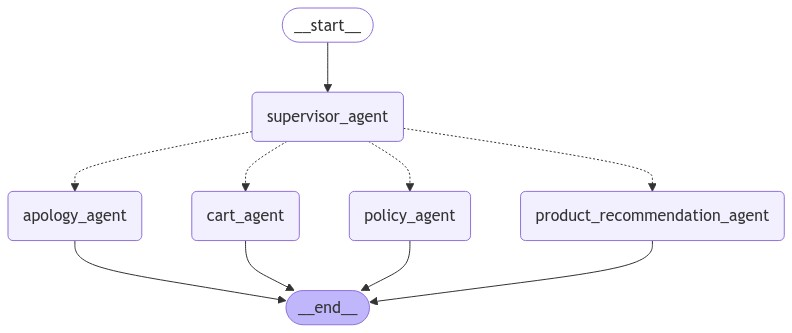

In [5]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph

# Initialise the graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("supervisor_agent", supervisor_agent)
workflow.add_node("product_recommendation_agent", product_recommendation_agent)
workflow.add_node("cart_agent", cart_agent)
workflow.add_node("policy_agent", policy_agent)
workflow.add_node("apology_agent", apology_agent)


# Add Edges
workflow.set_entry_point("supervisor_agent")
workflow.add_conditional_edges(
    source="supervisor_agent",
    path=supervisor_route,
    path_map={
        "product_recommendation_agent": "product_recommendation_agent",
        "apology_agent": "apology_agent",
        "cart_agent": "cart_agent",
        "policy_agent": "policy_agent"
    }
)
workflow.add_edge("product_recommendation_agent", END)
workflow.add_edge("cart_agent", END)
workflow.add_edge("policy_agent", END)
workflow.add_edge("apology_agent", END)

flower_graph = workflow.compile()

display(Image(flower_graph.get_graph().draw_mermaid_png()))

# 4. Test the Agents

In [21]:
from dotenv import load_dotenv
import os

load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

In [23]:
sparse_embeddings = FastEmbedSparse(
    model_name="Qdrant/bm25"
)

model_name = "jinaai/jina-embeddings-v3"
model_kwargs = {'device': 'cuda', 'trust_remote_code':True}
encode_kwargs = {'normalize_embeddings': False}
jina_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

embeddings = jina_embeddings

product_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    url=QDRANT_URL,
    prefer_grpc=True,
    api_key=QDRANT_API_KEY,
    collection_name="flowers",
    retrieval_mode=RetrievalMode.HYBRID,
)


policy_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    url=QDRANT_URL,
    prefer_grpc=True,
    api_key=QDRANT_API_KEY,
    collection_name="flowers_policy",
    retrieval_mode=RetrievalMode.HYBRID,
)


groq_llama3_1_70b = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    api_key=GROQ_API_KEY
)

Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: jinaai/jina-embeddings-v3
INFO:sentence_transformers.SentenceTransformer:5 prompts are loaded, with the keys: ['retrieval.query', 'retrieval.passage', 'separation', 'classification', 'text-matching']


## 4.1 Product Recommendation Agent

In [7]:
user_query = "Give me 3 flowers to choose for proposing to a girl i loved!!!"
#user_query = "Give 3 flowers to choose to attend funeral"
cust_id = "C001"
result = flower_graph.invoke(
    {
    "query":user_query,
    "cust_id":cust_id,
    "product_qdrant":product_qdrant,
    "policy_qdrant":policy_qdrant,
    "groq_llama3_1_70b":groq_llama3_1_70b
    }
)

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [8]:
result['supervisor_route_choice']

'product_recommendation_agent'

In [9]:
print(result['final_answer'])

Based on your need to propose to the girl you love, I would recommend the following three flower bouquets:

1. **Elsa Rose Bouquet**: 
**Reason to Buy**: This bouquet is a timeless expression of love and passion, featuring 12 stunning Elsa Roses that radiate beauty and grace. Elsa Roses symbolize admiration, gratitude, and gentle affection, making them the perfect choice for expressing your love and devotion. This bouquet is more than just flowers; it's a declaration of love that will surely leave a lasting impression on your loved one.

2. **My Girl Bouquet**: 
**Reason to Buy**: This bouquet is a sweet and gentle arrangement that adds a touch of magic to make your loved one's celebration even more memorable. The Pink Rose symbolizes affection and admiration, while the White Tulip represents the magical beginning of a love connection. This bouquet is a beautiful way to express your love and appreciation from the heart.

3. **Blooming Garden Bouquet**: 
**Reason to Buy**: This bouquet 

In [10]:
print(result['recommend_products'])

names=['Elsa Rose Bouquet', 'My Girl Bouquet', 'Blooming Garden Bouquet']


## 4.2 Cart Agent

In [12]:
user_query = "add 1 Elsa Rose Bouquet to cart and 2 My Girl Bouquet to cart"
result = flower_graph.invoke(
    {
    "query":user_query,
    "cust_id":cust_id,
    "product_qdrant":product_qdrant,
    "policy_qdrant":policy_qdrant,
    "groq_llama3_1_70b":groq_llama3_1_70b
    }
)

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [13]:
print(result['final_answer'])

Elsa Rose Bouquet added to cart successfully.
My Girl Bouquet added to cart successfully.



In [14]:
user_query = "add item to my cart"
result = flower_graph.invoke(
    {
    "query":user_query,
    "cust_id":cust_id,
    "product_qdrant":product_qdrant,
    "policy_qdrant":policy_qdrant,
    "groq_llama3_1_70b":groq_llama3_1_70b
    }
)

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [15]:
print(result['final_answer'])

No specific items were mentioned in the query.


## 4.3 Policy Agent

In [16]:
user_query = "Can I request for refund if I cancel my order ?"
result = flower_graph.invoke(
    {
    "query":user_query,
    "cust_id":cust_id,
    "product_qdrant":product_qdrant,
    "policy_qdrant":policy_qdrant,
    "groq_llama3_1_70b":groq_llama3_1_70b
    }
)
print(result['final_answer'])

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


You can request a refund if you cancel your order, but it depends on the type of order and the timeframe. For standard orders, you can cancel up to 24 hours before the scheduled delivery time and receive a full refund. However, for same-day delivery orders, no cancellations or refunds are allowed once the order is confirmed.


In [17]:
user_query = "did you guys open on sunday?"
result = flower_graph.invoke(
    {
    "query":user_query,
    "cust_id":cust_id,
    "product_qdrant":product_qdrant,
    "policy_qdrant":policy_qdrant,
    "groq_llama3_1_70b":groq_llama3_1_70b
    }
)
print(result['final_answer'])

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


No, we are closed on Sundays. Our operating hours are from 9:00 AM to 6:00 PM, Monday to Saturday.


## 4.4 Apology Agent

In [19]:
user_query = "Who is cristiano ronaldo ?"
result = flower_graph.invoke(
    {
    "query":user_query,
    "cust_id":cust_id,
    "product_qdrant":product_qdrant,
    "policy_qdrant":policy_qdrant,
    "groq_llama3_1_70b":groq_llama3_1_70b
    }
)
print(result['final_answer'])

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


I'm sorry, but I'm not able to assist with that query as it's not related to product recommendation, policy, or cart management. I'm here to help with shopping-related questions, but I don't have information on general knowledge topics like Cristiano Ronaldo. If you have a question about a product or your shopping experience, I'd be happy to try and help.
